# Experiments with projective transforms

This Notebook is needed to get acquainted with projective transforms in Scikit-image.

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import transform
# NumPy (for fast vectorised computations)
import numpy as np
# Math (for trigonometry)
from math import cos, sin
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/Moscow.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

## Step 1. Image load

In [4]:
image = io.imread(IM_PATH)

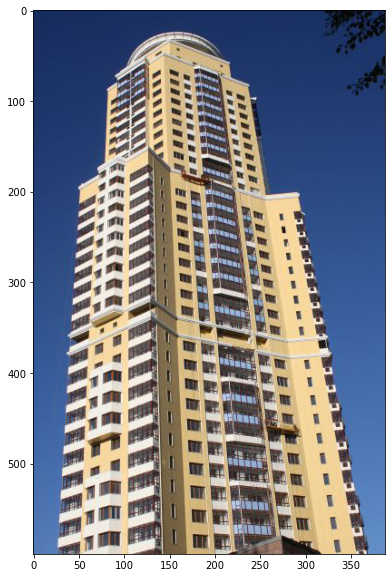

In [5]:
render_image(image)

Vanishing points detected with Hough transforms.

In [6]:
v_h, v_v = (484, 1490), (-676, 116)

## Step 2. Estimate the focal length

We will use estimation based on the length of image diagonal in pixels (see, e.g., [A. Gallagher, 2005] (Kodak, http://chenlab.ece.cornell.edu/people/Andy/publications/Andy_files/rotation_crv2005.pdf)).

In [7]:
focal_length = int((image.shape[0]**2 + image.shape[1]**2)**.5)

In [8]:
focal_length

714

## Step 3. Test of transforms

We need to translate the image such that its origin lies on the intersection of the vertical line going through the vertical vanishing point and the horizontal line going through the horizontal vanishing point.

In [9]:
cam2world_transform = transform.EuclideanTransform(matrix=np.array([[focal_length,            0, 0],
                                                                    [           0, focal_length, 0],
                                                                    [           0,            0, 1]]))
world2cam_transform = transform.EuclideanTransform(matrix=np.array([[focal_length**-1,                0, 0],
                                                                    [               0, focal_length**-1, 0],
                                                                    [               0,                0, 1]]))

In [10]:
origin_transform = transform.EuclideanTransform(translation=(-v_v[1], -v_h[0]))
inv_origin_transform = transform.EuclideanTransform(translation=(v_v[1], v_h[0]))

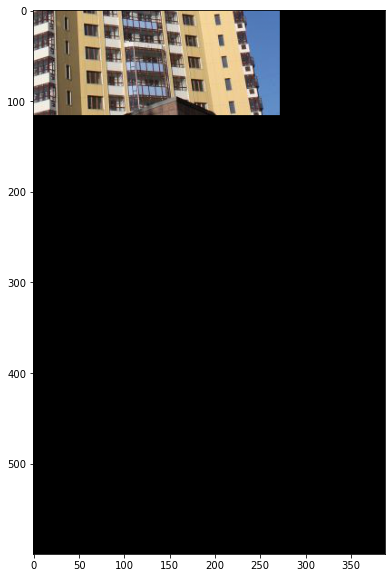

In [11]:
render_image(transform.warp(image, origin_transform.inverse))

In [34]:
focal_length = 1#714
rotate_transform = transform.EuclideanTransform(matrix=np.array([[focal_length,                     0,                      0],
                                                                 [0           , focal_length * cos(0.0006), -focal_length * sin(0.0006)],
                                                                 [0           ,                sin(0.0006),                 cos(0.0006)]]))

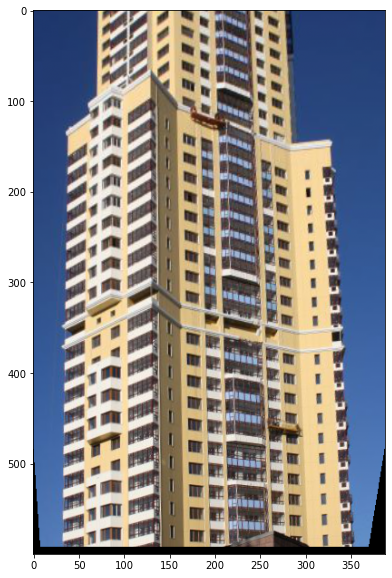

In [35]:
render_image(transform.warp(image, (origin_transform + rotate_transform + inv_origin_transform).inverse))